In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from custom.watermarks import add_watermark

In [ ]:
# url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"  # noqa: E501
# df_vacc = pd.read_csv(url)
# df_vacc = df_vacc.fillna(method="backfill")

# def get_vaccine_data(country, time_window=30, fully=False):
#     """ Recupera dati sulla frazione di vaccinati medi negli ultimi 30 giorni"""

#     df_vacc_country = df_vacc[df_vacc["location"] == country].iloc[2:, :]

#     if fully==False:
#         vacc_fully = np.array(df_vacc_country["people_vaccinated_per_hundred"])
#     else:
#         vacc_fully = np.array(df_vacc_country["people_fully_vaccinated_per_hundred"])

#     vacc_ultimi_Ngiorni = (vacc_fully[-1] + vacc_fully[-(time_window+1)])/2

#     return vacc_ultimi_Ngiorni

In [ ]:
# file_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"  
# df_deaths = pd.read_csv(file_deaths)

# def get_deaths(country, time_window=30):
#     decessi = np.array(df_deaths[df_deaths['Country/Region']==country].iloc[:, 4:].sum())
#     decessi_ultimi_Ngiorni = decessi[-1] - decessi[-(time_window+1)]
#     return decessi_ultimi_Ngiorni

### Importa dati da Our World in Data

In [2]:
file_owid = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df_global = pd.read_csv(file_owid)

In [78]:
df_global.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


### Definizione funzioni

In [38]:
def get_vaccine_data(country, time_window=30, fully=False):
    """ Recupera dati sulla frazione di vaccinati medi negli ultimi 30 giorni"""
    df_vacc_country = df_global[df_global["location"] == country]
    if fully==False:
        vacc_fully = np.array(df_vacc_country["people_vaccinated_per_hundred"][-(time_window+1):-1])
    else:
        vacc_fully = np.array(df_vacc_country["people_fully_vaccinated_per_hundred"][-(time_window+1):-1])
    vacc_ultimi_Ngiorni = np.average(vacc_fully[~np.isnan(vacc_fully)])
    return vacc_ultimi_Ngiorni

In [39]:
def get_deaths(country, time_window=30):
    """ Recupera dati sul numero assoluto di decessi negli ultimi 30 giorni"""
    decessi = np.array(df_global[df_global["location"] == country]['total_deaths'])
    decessi_ultimi_Ngiorni = decessi[-1] - decessi[-(time_window+1)]
    return decessi_ultimi_Ngiorni

In [55]:
def get_population(countries):
    """ Recupera dati sulla popolazione dei paesi specificati (input = lista)"""
    abitanti = {key: '' for key in countries}
    for el in countries:
        abitanti[el] = df_global[df_global["location"] == el]['population'].tolist()[-1]/1e6
    return abitanti

### Calcoli con diversi Paesi

In [72]:
# paesi = ['Bulgaria', 'Romania', 'Russia', 'United States', 'Greece', 'Israel', 'United Kingdom', 'Italy', 'Spain', 'Portugal']
paesi = ['Bulgaria', 'Romania', 'Russia', 'Cuba', 'United States', 'Greece', 'Israel', 'United Kingdom', 'Italy', 'Uruguay', 'Spain', 'Portugal']
paesi_label = ['Bulgaria', 'Romania', 'Russia', 'Cuba', 'Stati Uniti', 'Grecia', 'Israele', 'Regno Unito', 'Italia', 'Uruguay', 'Spagna', 'Portogallo']
abitanti = get_population(paesi)

dec_res=[]
vacc_res=[]

tw = 30

for p in paesi:
    vacc_res.append(get_vaccine_data(p, time_window = tw, fully=True))
    dec_res.append(get_deaths(p, time_window = tw)/abitanti[p])

watermark fontsize: 17, angle:-23.96


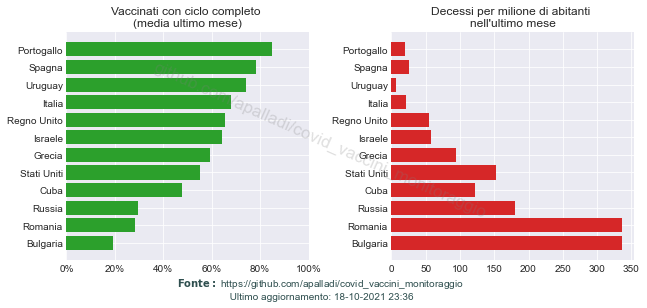

In [73]:
plt.style.use('seaborn-dark')

fig = plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.barh(paesi_label, vacc_res, color='C2')
plt.title('Vaccinati con ciclo completo \n(media ultimo mese)')
plt.grid()
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 20), ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.subplot(1, 2, 2)
plt.barh(paesi_label, dec_res, color='C3')
plt.title('Decessi per milione di abitanti \nnell\'ultimo mese')
plt.grid()
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())
plt.tight_layout()
plt.savefig('../risultati/correlazione_vaccini_decessi.png', dpi=300, bbox_inches="tight")
plt.show()

In [74]:
corr_coeff = np.corrcoef(vacc_res, dec_res)[0, 1]
print('Il coefficiente di correlazione tra frazione di vaccinati e decessi nell\'ultimo mese è', 
      round(corr_coeff, 2))

Il coefficiente di correlazione tra frazione di vaccinati e decessi nell'ultimo mese è -0.93


### Variazione della correlazione in funzione del tempo

In [75]:
def corr_window(tw):

    dec_res=[]
    vacc_res=[]

    for p in paesi:
        vacc_res.append(get_vaccine_data(p, time_window = tw, fully=True))
        dec_res.append(get_deaths(p, time_window = tw)/abitanti[p])

    corr_tw = np.corrcoef(vacc_res, dec_res)[0, 1]

    return corr_tw

In [76]:
tw_grid = np.arange(7, 121, 5)

corr_grid = [np.abs(corr_window(tw)) for tw in tw_grid]

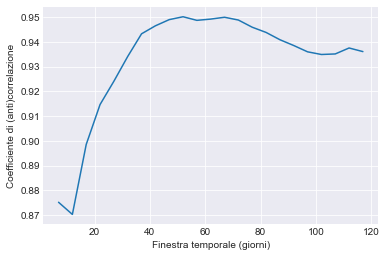

In [77]:
plt.plot(tw_grid, corr_grid)
plt.xlabel('Finestra temporale (giorni)')
plt.ylabel('Coefficiente di (anti)correlazione')
plt.grid()
plt.show()